In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
X = np.empty((100, 2))
X[:, 0] = np.random.uniform(0., 100., size=100)
X[:, 1] = 0.75 * X[:, 0] + 3. + np.random.normal(0, 10., size=100)

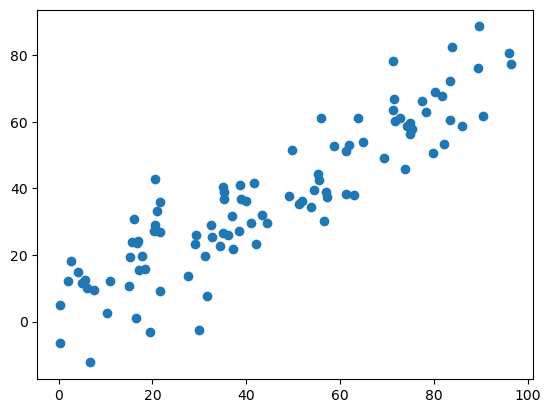

In [3]:
plt.scatter(X[:, 0], X[:, 1])

## demean

In [4]:
def demean(X):
    return X - np.mean(X, axis = 0)

In [5]:
X_demean = demean(X)

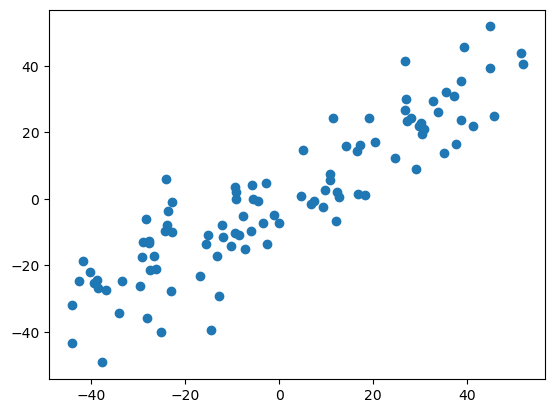

In [6]:
plt.scatter(X_demean[:, 0], X_demean[:, 1])

In [7]:
np.mean(X_demean[:, 0])

4.476419235288631e-15

In [8]:
np.mean(X_demean[:, 1])

1.0871303857129533e-14

## 梯度上升法

In [9]:
def f(w, X):
    return np.sum((X.dot(w)**2)) / len(X)

def df_math(w, X):
    return X.T.dot(X.dot(w)) * 2. / len(X)

def df_debug(w, X, epsilon = 0.0001):
    res = np.empty(len(w))
    for i in range(len(w)):
        w_1 = w.copy()
        w_2 = w.copy()
        w_1[i] += epsilon
        w_2[i] -= epsilon
        res[i] = (f(w_1, X) - f(w_2, X)) / (2 * epsilon)
    
    return res

'''
df_debug_my_way错误原因：f函数返回的是一个数，所以不可能用向量化的方式计算每一个维度的梯度上升方向
'''
def df_debug_my_way(w, X, epsilon = 0.0001):
    w_1 = w.copy()
    w_2 = w.copy()
    w_1 = w_1 + np.full(shape = (w_1.shape[0],), fill_value = epsilon)
    w_2 = w_2 - np.full(shape = (w_2.shape[0],), fill_value = epsilon)
    res = (f(w_1, X) - f(w_2, X)) / (2 * epsilon)
    print(res.shape)
    return res

def direction(w):
    return w / np.linalg.norm(w)

def gradient_ascent(df, X, initial_w, eta, n_iters = 1e4, epsilon=1e-8):
    
    w = direction(initial_w)# w表示的是坐标轴。我们要的是坐标轴的方向，大小没有意义。
    cur_iter = 0

    while cur_iter < n_iters:
        gradient = df(w, X)
        last_w = w
        w = w + eta * gradient
        w = direction(w) # 注意1：每次求一个单位方向
        if(abs(f(w, X) - f(last_w, X)) < epsilon):
            break
            
        cur_iter += 1

    return w

In [10]:
initial_w = np.random.random(X.shape[1]) #注意：坐标系不能从0向量开始。0向量没有方向
initial_w

array([0.6000643 , 0.93400524])

In [11]:
eta = 0.001 # 注意：不能使用standardScaler标准化数据.

In [12]:
gradient_ascent(df_debug, X_demean, initial_w, eta)

array([0.77675267, 0.62980575])

In [15]:
gradient_ascent(df_math, X_demean, initial_w, eta)

array([0.77675267, 0.62980575])

In [16]:
w = gradient_ascent(df_math, X_demean, initial_w, eta)

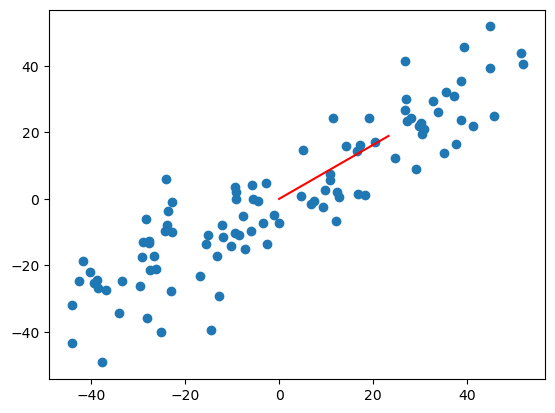

In [19]:
plt.scatter(X_demean[:, 0], X_demean[:, 1])
plt.plot([0, w[0]*30], [0, w[1]*30], color = 'r')
'''
`[0，w[0]*30]`：直线的x坐标。它从x轴（水平轴）上的0开始，一直到“w[0]*30”`w[0]’可能是与x轴相关联的权重或系数。
`[0，w[1]*30]`：直线的y坐标。它从y轴（垂直轴）上的0开始，一直到“w[1]*30”`w[1]’大概是与y轴相关联的权重或系数。
因此，这一行代码正在绘制一个从原点（0，0）开始并结束于点（“w[0]*30”，“w[1]*30”）的矢量。这是二维空间中矢量的可视化，
矢量的颜色为红色。假设值“w[0]”和“w[1]”是矢量的分量，矢量按30的因子缩放
'''

### 使用极端数据集测试

In [20]:
X2 = np.empty((100, 2))
X2[:, 0] = np.random.uniform(0., 100., size = 100)
X2[:, 1] = 0.75 * X2[:, 0] + 3.

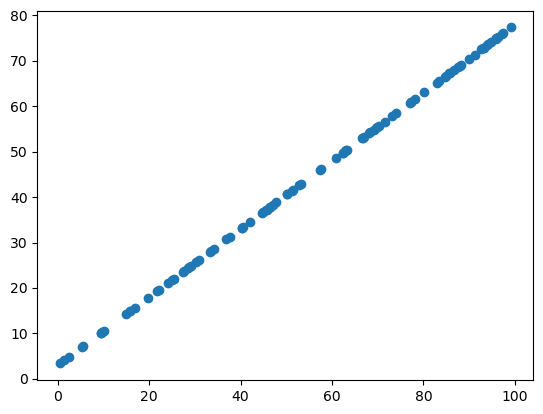

In [22]:
plt.scatter(X2[:, 0], X2[:, 1])

In [70]:
X2_demean = demean(X2)
w2 = gradient_ascent(df_math, X2_demean, initial_w, eta)
w2

array([0.79999976, 0.60000032])

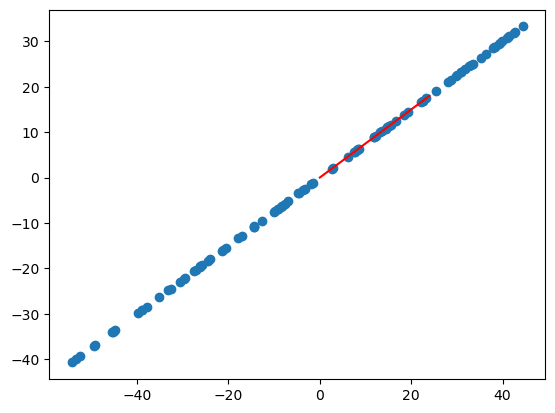

In [26]:
plt.scatter(X2_demean[:, 0], X2_demean[:, 1])
plt.plot([0, w2[0] * 30], [0, w2[1] * 30], color = 'r')

### 随机梯度上升法

In [50]:
def df_sad(w, X_i):
    return 2. * X_i.T.dot(X_i.dot(w))

def gradient_sad(df, X, initial_w, n_iters = 5, t0 = 5, t1 = 50): #t0 t1可以设置成别的值，比如t0 = 0.75, t1 = 150
    def learning_rate(t):
        return t0 / (t + t1)
    
    w = initial_w
    w = direction(w)
    m = len(X)
    for i_iter in range(n_iters):
        indexes = np.random.permutation(m)
        X_new = X[indexes, :]
        for i in range(m):
            gradient = df_sgd(w, X_new[i])
            w = w + learning_rate(i_iter * m + i) *gradient
            w = direction(w)
    
    return w

In [51]:
w3 = gradient_sad(df_sgd, X2_demean, initial_w)
w3

array([0.8, 0.6])

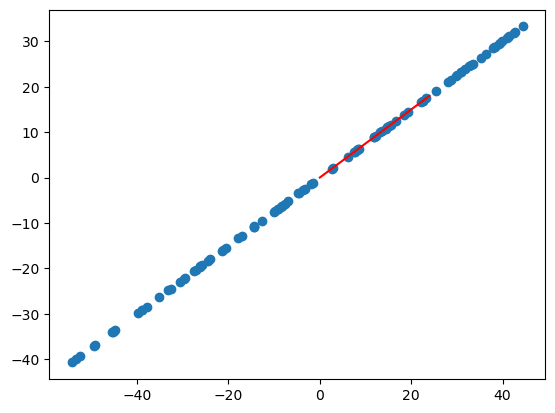

In [52]:
plt.scatter(X2_demean[:, 0], X2_demean[:, 1])
plt.plot([0, w3[0] * 30], [0, w3[1] * 30], color = 'r')

### 小批量上升法

In [62]:
def df_batch_sad(w, X_b): 
    return 2. * X_b.T.dot(X_b.dot(w)) / len(X_b)

def gradient_batch_sad(df, X, initial_w, batch_size = 9, n_iters = 5, t0 = 5, t1 = 50): 
                                            #t0 t1可以设置成别的值，比如t0 = 0.75, t1 = 150
    def learning_rate(t):
        return t0 / (t + t1)
    
    w = initial_w
    w = direction(w)
    m = len(X)
    for i_iter in range(n_iters):
        indexes = np.random.permutation(m)
        X_new = X[indexes, :]
        for i in range(0, m, batch_size):
            gradient = df_batch_sad(w, X_new[i:i+batch_size])
            w = w + learning_rate(i_iter * m + i) *gradient
            w = direction(w)
    
    return w

In [63]:
w4 = gradient_batch_sad(df_batch_sad, X2_demean, initial_w)
w4

array([0.8, 0.6])

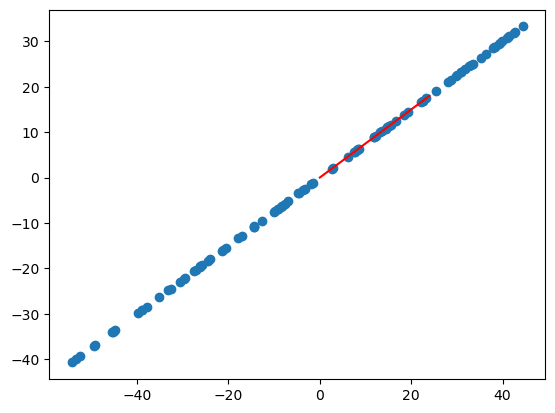

In [64]:
plt.scatter(X2_demean[:, 0], X2_demean[:, 1])
plt.plot([0, w4[0] * 30], [0, w4[1] * 30], color = 'r')

### 关于一次遍历n个元素的方法

In [69]:
# 创建一个示例数组
arr = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])

# 定义每次遍历的子集大小
batch_size = 10

# 计算数组的长度
arr_length = len(arr)

# 使用循环遍历整个数组
for i in range(0, arr_length, batch_size):
    
    # 获取当前子集
    batch = arr[i:i+batch_size]
    
    print("i = ", i)
    # 打印当前子集
    print("batch = ",batch)



i =  0
batch =  [ 1  2  3  4  5  6  7  8  9 10]
i =  10
batch =  [11 12 13 14 15 16 17 18 19 20]
i =  20
batch =  [21 22]
